Define Directories and Arguments

In [1]:
import os
import torch

# Set directories
project_dir = "/content/drive/MyDrive/Classes/Fourth/Fall/CS2822R/CS2822_Final_Project"
models_dir = os.path.join(project_dir, "Models")
datasets_dir = os.path.join(project_dir, "Datasets")
data_dir = os.path.join(datasets_dir, "spawrious224__o2o_medium.tar.gz")
MODEL_NAME = "resnet18.a1_in1k"
model_checkpoint = "o2o_easy_resnet18.a1-e=2-lr=0.01_limit=20.pt"
cls = "corgi"

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print("Device: ", device)

# Artificially create args
class Args:
    def __init__(self, model="siglip",
                 dataset="o2o_easy", data_dir='/content/data/',
                 num_epochs=2, val_split=0.1,
                 batch_size=12,num_workers=2, lr=0.01, momentum=0.9, num_images = 300):
        self.model = model
        self.dataset = dataset
        self.data_dir = data_dir
        self.num_epochs = num_epochs
        self.val_split = val_split
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.lr = lr
        self.momentum = momentum
        self.num_images = num_images

# Initialize Args

args = Args(model = "resnet", batch_size=32, num_images=500)

Device:  cuda


#Load Dependencies

In [2]:
import argparse

import torch
import torch.optim as optim
from torch import nn
from torch.nn import Module
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm
from tqdm.auto import tqdm
import timm
import wandb
import os

# 0. Spawrious Source Code

Initializes dataloaders and dataset lists -- with some modifications from source code.


In [3]:
import os
import tarfile
import urllib
import urllib.request
from typing import Any, Tuple

import torch
from PIL import Image
from torch.utils.data import ConcatDataset, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import timm
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# MODEL_NAME = "vit_so400m_patch14_siglip_384"
# MODEL_NAME = 'swin_base_patch4_window7_224.ms_in22k_ft_in1k'
# MODEL_NAME = 'deit3_base_patch16_224.fb_in22k_ft_in1k'
# MODEL_NAME = 'beit_base_patch16_224.in22k_ft_in22k_in1k'
# MODEL_NAME = 'eva02_base_patch14_448.mim_in22k_ft_in22k_in1k'
# MODEL_NAME = 'levit_128s.fb_dist_in1k'

def set_model_name(name):
    global MODEL_NAME
    MODEL_NAME = name


def _extract_dataset_from_tar(
    tar_file_name: str, data_dir: str
) -> None:
    tar_file_dst = os.path.join(data_dir, tar_file_name)
    print("Extracting dataset...")
    tar = tarfile.open(tar_file_dst, "r:gz")
    tar.extractall(os.path.dirname(tar_file_dst))
    tar.close()


def _download_dataset_if_not_available(
    dataset_name: str, data_dir: str, remove_tar_after_extracting: bool = True
) -> None:
    """
    datasets.txt file, which is present in the data_dir, is used to check if the dataset is already extracted. If the dataset is already extracted, then the tar file is not downloaded again.
    """
    data_dir = data_dir.split("/spawrious224/")[
        0
    ]  # in case people pass in the wrong root_dir
    os.makedirs(data_dir, exist_ok=True)
    dataset_name = dataset_name.lower()
    if dataset_name.split("_")[0] == "m2m":
        dataset_name = "entire_dataset"
    url_dict = {
        "entire_dataset": "https://www.dropbox.com/s/hofkueo8qvaqlp3/spawrious224__entire_dataset.tar.gz?dl=1",
        "o2o_easy": "https://www.dropbox.com/s/kwhiv60ihxe3owy/spawrious224__o2o_easy.tar.gz?dl=1",
        "o2o_medium": "https://www.dropbox.com/s/x03gkhdwar5kht4/spawrious224__o2o_medium.tar.gz?dl=1",
        "o2o_hard": "https://www.dropbox.com/s/p1ry121m2gjj158/spawrious224__o2o_hard.tar.gz?dl=1",
        # "m2m": "https://www.dropbox.com/s/5usem63nfub266y/spawrious__m2m.tar.gz?dl=1",
    }
    tar_file_name = f"spawrious224__{dataset_name}.tar.gz"
    tar_file_dst = os.path.join(data_dir, tar_file_name)
    url = url_dict[dataset_name]

    # check if the dataset is already extracted
    if _check_images_availability(data_dir, dataset_name):
        print("Dataset already downloaded and extracted.")
        return
    # check if the tar file is already downloaded
    else:
        if os.path.exists(tar_file_dst):
            print("Dataset already downloaded. Extracting...")
            _extract_dataset_from_tar(
                tar_file_name, data_dir
            )
            return
        # download the tar file and extract from it
        else:
            print("Dataset not found. Downloading...")
            response = urllib.request.urlopen(url)
            total_size = int(response.headers.get("Content-Length", 0))
            block_size = 1024
            # Track progress of download
            progress_bar = tqdm(total=total_size, unit="iB", unit_scale=True)
            with open(tar_file_dst, "wb") as f:
                while True:
                    buffer = response.read(block_size)
                    if not buffer:
                        break
                    f.write(buffer)
                    progress_bar.update(len(buffer))
            progress_bar.close()
            print("Dataset downloaded. Extracting...")
            _extract_dataset_from_tar(
                tar_file_name, data_dir
            )
            return


class CustomImageFolder(Dataset):
    """
    A class that takes one folder at a time and loads a set number of images in a folder and assigns them a specific class
    """

    def __init__(
        self, folder_path, class_index, location_index, limit=None, transform=None
    ):
        self.folder_path = folder_path
        self.class_index = class_index
        self.location_index = location_index
        self.image_paths = [
            os.path.join(folder_path, img)
            for img in os.listdir(folder_path)
            if img.endswith((".png", ".jpg", ".jpeg"))
        ]
        if limit:
            self.image_paths = self.image_paths[:limit]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index: int) -> Tuple[Any, Any, Any]:
        img_path = self.image_paths[index]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        class_label = torch.tensor(self.class_index, dtype=torch.long)
        location_label = torch.tensor(self.location_index, dtype=torch.long)
        return img, class_label, location_label


class MultipleDomainDataset:
    N_STEPS = 5001  # Default, subclasses may override
    CHECKPOINT_FREQ = 100  # Default, subclasses may override
    N_WORKERS = 8  # Default, subclasses may override
    ENVIRONMENTS = None  # Subclasses should override
    INPUT_SHAPE = None  # Subclasses should override

    def __getitem__(self, index):
        return self.datasets[index]

    def __len__(self):
        return len(self.datasets)


def build_combination(benchmark_type, group, test, filler=None):
    total = 3168
    combinations = {}
    if "m2m" in benchmark_type:
        counts = [total, total]
        combinations["train_combinations"] = {
            ("bulldog",): [(group[0], counts[0]), (group[1], counts[1])],
            ("dachshund",): [(group[1], counts[0]), (group[0], counts[1])],
            ("labrador",): [(group[2], counts[0]), (group[3], counts[1])],
            ("corgi",): [(group[3], counts[0]), (group[2], counts[1])],
        }
        combinations["test_combinations"] = {
            ("bulldog",): [test[0], test[1]],
            ("dachshund",): [test[1], test[0]],
            ("labrador",): [test[2], test[3]],
            ("corgi",): [test[3], test[2]],
        }
    else:
        counts = [int(0.97 * total), int(0.87 * total)]
        combinations["train_combinations"] = {
            ("bulldog",): [(group[0], counts[0]), (group[0], counts[1])],
            ("dachshund",): [(group[1], counts[0]), (group[1], counts[1])],
            ("labrador",): [(group[2], counts[0]), (group[2], counts[1])],
            ("corgi",): [(group[3], counts[0]), (group[3], counts[1])],
            ("bulldog", "dachshund", "labrador", "corgi"): [
                (filler, total - counts[0]),
                (filler, total - counts[1]),
            ],
        }
        combinations["test_combinations"] = {
            ("bulldog",): [test[0], test[0]],
            ("dachshund",): [test[1], test[1]],
            ("labrador",): [test[2], test[2]],
            ("corgi",): [test[3], test[3]],
        }
    return combinations


def _get_combinations(benchmark_type: str) -> Tuple[dict, dict]:
    combinations = {
        "o2o_easy": (
            ["desert", "jungle", "dirt", "snow"],
            ["dirt", "snow", "desert", "jungle"],
            "beach",
        ),
        "o2o_medium": (
            ["mountain", "beach", "dirt", "jungle"],
            ["jungle", "dirt", "beach", "snow"],
            "desert",
        ),
        "o2o_hard": (
            ["jungle", "mountain", "snow", "desert"],
            ["mountain", "snow", "desert", "jungle"],
            "beach",
        ),
        "m2m_hard": (
            ["dirt", "jungle", "snow", "beach"],
            ["snow", "beach", "dirt", "jungle"],
            None,
        ),
        "m2m_easy": (
            ["desert", "mountain", "dirt", "jungle"],
            ["dirt", "jungle", "mountain", "desert"],
            None,
        ),
        "m2m_medium": (
            ["beach", "snow", "mountain", "desert"],
            ["desert", "mountain", "beach", "snow"],
            None,
        ),
    }
    if benchmark_type not in combinations:
        raise ValueError("Invalid benchmark type")
    group, test, filler = combinations[benchmark_type]
    return build_combination(benchmark_type, group, test, filler)


class SpawriousBenchmark(MultipleDomainDataset):
    ENVIRONMENTS = ["Test", "SC_group_1", "SC_group_2"]
    input_shape = (3, 224, 224)
    num_classes = 4
    class_list = ["bulldog", "corgi", "dachshund", "labrador"]
    locations_list = ["desert", "jungle", "dirt", "mountain", "snow", "beach"]

    def __init__(self, benchmark, root_dir, augment=True):
        combinations = _get_combinations(benchmark.lower())
        self.type1 = benchmark.lower().startswith("o2o")
        train_datasets, test_datasets = self._prepare_data_lists(
            combinations["train_combinations"],
            combinations["test_combinations"],
            root_dir,
            augment,
        )
        self.datasets = [ConcatDataset(test_datasets)] + train_datasets

    def get_train_dataset(self):
        return torch.utils.data.ConcatDataset(self.datasets[1:])

    def get_test_dataset(self):
        return self.datasets[0]

    # Prepares the train and test data lists by applying the necessary transformations.
    def _prepare_data_lists(
        self, train_combinations, test_combinations, root_dir, augment
    ):
        backbone = timm.create_model(
            # "vit_so400m_patch14_siglip_384",
            MODEL_NAME,
            pretrained=True,
            num_classes=0,
        ).eval()
        self.data_config = timm.data.resolve_model_data_config(backbone)
        test_transforms = timm.data.create_transform(
            **self.data_config, is_training=False
        )

        # test_transforms = transforms.Compose(
        #     [
        #         transforms.Resize((self.input_shape[1], self.input_shape[2])),
        #         transforms.transforms.ToTensor(),
        #         transforms.Normalize(
        #             mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        #         ),
        #     ]
        # )

        if augment:
            train_transforms = timm.data.create_transform(
                **self.data_config, is_training=True
            )
        else:
            train_transforms = test_transforms
        print("Creating Training Dataset:")
        train_data_list = self._create_data_list(
            train_combinations, root_dir, train_transforms
        )
        print("Creating Testing Dataset:")
        test_data_list = self._create_data_list(
            test_combinations, root_dir, test_transforms
        )

        return train_data_list, test_data_list

    # Creates a list of datasets based on the given combinations and transformations.
    def _create_data_list(self, combinations, root_dir, transforms):
        data_list = []
        if isinstance(combinations, dict):
            # Build class groups for a given set of combinations, root directory, and transformations.
            for_each_class_group = []
            cg_index = 0
            for classes, comb_list in combinations.items():
                for_each_class_group.append([])
                for ind, location_limit in enumerate(comb_list):
                    if isinstance(location_limit, tuple):
                        location, limit = location_limit
                    else:
                        location, limit = location_limit, None
                    cg_data_list = []
                    for cls in classes:
                        path = os.path.join(
                            root_dir,
                            "spawrious224",
                            f"{0 if not self.type1 else ind}/{location}/{cls}",
                        )
                        print(f"    Combination: {0 if not self.type1 else ind}/{location}/{cls}")
                        print(f"    Limit: {limit}")
                        data = CustomImageFolder(
                            folder_path=path,
                            class_index=self.class_list.index(cls),
                            location_index=self.locations_list.index(location),
                            limit=limit,
                            transform=transforms,
                        )
                        cg_data_list.append(data)

                    for_each_class_group[cg_index].append(ConcatDataset(cg_data_list))
                cg_index += 1

            for group in range(len(for_each_class_group[0])):
                data_list.append(
                    ConcatDataset(
                        [
                            for_each_class_group[k][group]
                            for k in range(len(for_each_class_group))
                        ]
                    )
                )
        else:
            for location in combinations:
                path = os.path.join(root_dir, f"{0}/{location}/")
                data = ImageFolder(root=path, transform=transforms)
                data_list.append(data)

        return data_list


def _check_images_availability(root_dir: str, dataset_type: str) -> bool:
    # Get the combinations for the given dataset type
    root_dir = root_dir.split("/spawrious224/")[
        0
    ]  # in case people pass in the wrong root_dir
    if dataset_type == "entire_dataset":
        for dataset in ["0", "1", "domain_adaptation_ds"]:
            for location in ["snow", "jungle", "desert", "dirt", "mountain", "beach"]:
                for cls in ["bulldog", "corgi", "dachshund", "labrador"]:
                    path = os.path.join(
                        root_dir, "spawrious224", f"{dataset}/{location}/{cls}"
                    )
                    if not os.path.exists(path) or not any(
                        img.endswith((".png", ".jpg", ".jpeg"))
                        for img in os.listdir(path)
                    ):
                        return False
        return True
    combinations = _get_combinations(dataset_type.lower())

    # Extract the train and test combinations
    train_combinations = combinations["train_combinations"]
    test_combinations = combinations["test_combinations"]

    # Check if the relevant images for each combination are present in the root directory
    for combination in [train_combinations, test_combinations]:
        for classes, comb_list in combination.items():
            for ind, location_limit in enumerate(comb_list):
                if isinstance(location_limit, tuple):
                    location, limit = location_limit
                else:
                    location, limit = location_limit, None

                for cls in classes:
                    path = os.path.join(
                        root_dir,
                        "spawrious224",
                        f"{0 if not dataset_type.lower().startswith('o2o') else ind}/{location}/{cls}",
                    )

                    # If the path does not exist or there are no relevant images, return False
                    if not os.path.exists(path) or not any(
                        img.endswith((".png", ".jpg", ".jpeg"))
                        for img in os.listdir(path)
                    ):
                        return False

    # If all the required images are present, return True
    return True


def get_spawrious_dataset(root_dir: str, dataset_name: str = "entire_dataset"):
    """
    Returns the dataset as a torch dataset, and downloads dataset if dataset is not already available.

    By default, the entire dataset is downloaded, which is necessary for m2m experiments, and domain adaptation experiments
    """
    root_dir = root_dir.split("/spawrious224/")[
        0
    ]  # in case people pass in the wrong root_dir
    assert dataset_name.lower() in {
        "o2o_easy",
        "o2o_medium",
        "o2o_hard",
        "m2m_easy",
        "m2m_medium",
        "m2m_hard",
        "m2m",
        "entire_dataset",
    }, f"Invalid dataset type: {dataset_name}"
    _download_dataset_if_not_available(dataset_name, root_dir)
    # TODO: get m2m to use entire dataset, not half of it
    return SpawriousBenchmark(dataset_name, root_dir, augment=True)

In [4]:
# Class to modify model
class ClassifierOnTop(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = timm.create_model(
            # "vit_so400m_patch14_siglip_384",
            MODEL_NAME,
            pretrained=True,
            num_classes=0,
        ).eval()
        self.linear = nn.Linear(1152, num_classes)
        if MODEL_NAME == 'swin_base_patch4_window7_224.ms_in22k_ft_in1k':
            self.linear = nn.Linear(1024, num_classes)
        elif MODEL_NAME == 'deit3_base_patch16_224.fb_in22k_ft_in1k':
            self.linear = nn.Linear(768, num_classes)
        elif MODEL_NAME == 'beit_base_patch16_224.in22k_ft_in22k_in1k':
            self.linear = nn.Linear(768, num_classes)
        elif MODEL_NAME == 'eva02_base_patch14_448.mim_in22k_ft_in22k_in1k':
            self.linear = nn.Linear(768, num_classes)
        elif MODEL_NAME == 'levit_128s.fb_dist_in1k':
            self.linear = nn.Linear(384, num_classes)

    def forward(self, x):
        with torch.no_grad():
            x = self.backbone(x)
        return self.linear(x)


def get_model(args: argparse.Namespace) -> Module:
    if args.model == "siglip":
        model = ClassifierOnTop(num_classes=4)
    else:
        model = models.resnet18(pretrained=True)
        model.fc = torch.nn.Linear(512, 4)
    return model


#1. Load Dataset

In [6]:
# Mount google drive to local dir
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
# Create data dir
!mkdir /content/data

In [8]:
# Set Model Name (using global var)
set_model_name(MODEL_NAME)

# Create custom dataset object using args define above
# This function will extract the dataset from the tar.gz file, and
# sample images according to the arguments (either one-to-one subject-background,
# or many-to-many)

'''

OPTIONAL - Create dataset using entire SPAWRIOUS dataset

# Copy data from drive
!cp $drive_data_dir /content/data/

spawrious = get_spawrious_dataset(dataset_name=args.dataset, root_dir=args.data_dir)

# Pull train, test, and split val set
train_set = spawrious.get_train_dataset()
test_set = spawrious.get_test_dataset()
val_size = int(len(train_set) * args.val_split)
train_set, val_set = torch.utils.data.random_split(
    train_set, [len(train_set) - val_size, val_size]
)


# Create dataloader objects -- to be passed through model
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
)
'''

'\n\nOPTIONAL - Create dataset using entire SPAWRIOUS dataset\n\n# Copy data from drive\n!cp $drive_data_dir /content/data/\n\nspawrious = get_spawrious_dataset(dataset_name=args.dataset, root_dir=args.data_dir)\n\n# Pull train, test, and split val set\ntrain_set = spawrious.get_train_dataset()\ntest_set = spawrious.get_test_dataset()\nval_size = int(len(train_set) * args.val_split)\ntrain_set, val_set = torch.utils.data.random_split(\n    train_set, [len(train_set) - val_size, val_size]\n)\n\n\n# Create dataloader objects -- to be passed through model\ntrain_loader = torch.utils.data.DataLoader(\n    train_set,\n    batch_size=args.batch_size,\n    shuffle=True,\n    num_workers=args.num_workers,\n)\nval_loader = torch.utils.data.DataLoader(\n    val_set, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers\n)\ntest_loader = torch.utils.data.DataLoader(\n    test_set,\n    batch_size=args.batch_size,\n    shuffle=False,\n    num_workers=args.num_workers,\n)\n'

#2. Load Model

In [9]:
# Get model (must be stored in models dir)
# Checks if GPU is available first
if torch.cuda.is_available():
    model_weights = torch.load(os.path.join(models_dir, model_checkpoint))
else:
    model_weights = torch.load(os.path.join(models_dir, model_checkpoint), map_location=torch.device('cpu'))

<ipython-input-9-e395d9224343>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_weights = torch.load(os.path.join(models_dir, model_checkpoint))


In [10]:
# Create model backbone (base model)
model = timm.create_model(
            # "vit_so400m_patch14_siglip_384",
            MODEL_NAME,
            pretrained=True,
            num_classes=4).eval()

# Add linear readout for 4 clases, wraps model in custom model class
#model = get_model(args)

# Add on classifier for last 4 classes
model.load_state_dict(model_weights)

# set ENTIRE model to eval mode
model.eval()
if torch.cuda.is_available():
    model.to('cuda')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [11]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

#3. Create Custom Dataloader and Dataset for experiments


Extract only one class (Corgi) and location (snow) as its own dataset

In [12]:
import tarfile

# Unzip thes snow-corgi dataset
drive_dir = os.path.join(datasets_dir, "1-snow-corgi.tar.gz")
!cp $drive_dir /content/data
tar_file = os.path.join('/content/data', drive_dir.split('/')[-1])
data_dir = "/content/data/spawrious224/1/snow/"

# Extract the snow-corgi dataset
with tarfile.open(tar_file, 'r:gz') as tar:  # Use 'r' for .tar and 'r:gz' for .tar.gz
    tar.extractall(path=data_dir)

Images loaded:  3168
Transforms used:
 Compose(
    Resize(size=235, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
Example Image: 


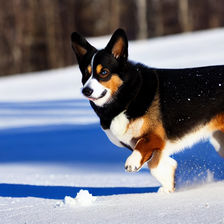

In [13]:
import numpy as np

# Retrieve model transform
config = timm.data.resolve_model_data_config(model)
transform = timm.data.create_transform(**config, is_training=False,)

# Checkout the specific dog you are interested in
class_dir = os.path.join("/content/data/spawrious224/1/snow", cls)

# Create a custom image folder (the Spawrious custom class for datasets)
class_data_list = CustomImageFolder(class_dir,
                                   class_index=1, location_index=4,
                                   transform = transform)
no_transforms_list = CustomImageFolder(class_dir,
                                   class_index=1, location_index=4,
                                   transform = None)

print("Images loaded: ", len(class_data_list))
# Checkout model transforms
print("Transforms used:\n", transform)
print("Example Image: ")
no_transforms_list[np.random.randint(len(class_data_list))][0]


#4. Concept Extraction with ACE

## TCAV Source Code

In [14]:
"""
Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

from scipy.stats import ttest_ind
import numpy as np
import os
import torch
# import tensorflow as tf
# from tcav.tcav_results.results_pb2 import Result, Results

_KEYS = [
    "cav_key", "cav_concept", "negative_concept", "target_class", "i_up",
    "val_directional_dirs_abs_mean", "val_directional_dirs_mean",
    "val_directional_dirs_std", "note", "alpha", "bottleneck"
]


# def create_session(timeout=10000, interactive=True):
#   """Create a tf session for the model.
#   # This function is slight motification of code written by Alex Mordvintsev
#
#   Args:
#     timeout: tfutil param.
#
#   Returns:
#     TF session.
#   """
#   graph = tf.Graph()
#   config = tf.compat.v1.ConfigProto()
#   config.gpu_options.allow_growth = True
#   config.operation_timeout_in_ms = int(timeout*1000)
#   if interactive:
#     return tf.compat.v1.InteractiveSession(graph=graph, config=config)
#   else:
#     return tf.compat.v1.Session(graph=graph, config=config)


def flatten(nested_list):
  """Flatten a nested list."""
  return [item for a_list in nested_list for item in a_list]


def process_what_to_run_expand(pairs_to_test,
                               random_counterpart=None,
                               num_random_exp=100,
                               random_concepts=None):
  """Get concept vs. random or random vs. random pairs to run.

    Given set of target, list of concept pairs, expand them to include
     random pairs. For instance [(t1, [c1, c2])...] becomes
     [(t1, [c1, random1],
      (t1, [c1, random2],...
      (t1, [c2, random1],
      (t1, [c2, random2],...]

  Args:
    pairs_to_test: [(target1, concept1), (target1, concept2), ...,
                    (target2, concept1), (target2, concept2), ...]
    random_counterpart: random concept that will be compared to the concept.
    num_random_exp: number of random experiments to run against each concept.
    random_concepts: A list of names of random concepts for the random
                     experiments to draw from. Optional, if not provided, the
                     names will be random500_{i} for i in num_random_exp.

  Returns:
    all_concepts: unique set of targets/concepts
    new_pairs_to_test: expanded
  """
  def get_random_concept(i):
    return (random_concepts[i] if random_concepts
            else 'random500_{}'.format(i))

  new_pairs_to_test = []
  for (target, concept_set) in pairs_to_test:
    new_pairs_to_test_t = []
    # if only one element was given, this is to test with random.
    if len(concept_set) == 1:
      i = 0
      while len(new_pairs_to_test_t) < min(100, num_random_exp):
        # make sure that we are not comparing the same thing to each other.
        if concept_set[0] != get_random_concept(
            i) and random_counterpart != get_random_concept(i):
          new_pairs_to_test_t.append(
              (target, [concept_set[0], get_random_concept(i)]))
        i += 1
    elif len(concept_set) > 1:
      new_pairs_to_test_t.append((target, concept_set))
    else:
      print('PAIR NOT PROCCESSED')
    new_pairs_to_test.extend(new_pairs_to_test_t)

  all_concepts = list(set(flatten([cs + [tc] for tc, cs in new_pairs_to_test])))

  return all_concepts, new_pairs_to_test


def process_what_to_run_concepts(pairs_to_test):
  """Process concepts and pairs to test.

  Args:
    pairs_to_test: a list of concepts to be tested and a target (e.g,
     [ ("target1",  ["concept1", "concept2", "concept3"]),...])

  Returns:
    return pairs to test:
       target1, concept1
       target1, concept2
       ...
       target2, concept1
       target2, concept2
       ...

  """

  pairs_for_sstesting = []
  # prepare pairs for concpet vs random.
  for pair in pairs_to_test:
    for concept in pair[1]:
      pairs_for_sstesting.append([pair[0], [concept]])
  return pairs_for_sstesting


def process_what_to_run_randoms(pairs_to_test, random_counterpart):
  """Process concepts and pairs to test.

  Args:
    pairs_to_test: a list of concepts to be tested and a target (e.g,
     [ ("target1",  ["concept1", "concept2", "concept3"]),...])
    random_counterpart: a random concept that will be compared to the concept.

  Returns:
    return pairs to test:
          target1, random_counterpart,
          target2, random_counterpart,
          ...
  """
  # prepare pairs for random vs random.
  pairs_for_sstesting_random = []
  targets = list(set([pair[0] for pair in pairs_to_test]))
  for target in targets:
    pairs_for_sstesting_random.append([target, [random_counterpart]])
  return pairs_for_sstesting_random


# helper functions to write summary files
def print_results(results, random_counterpart=None, random_concepts=None, num_random_exp=100,
    min_p_val=0.05):
  """Helper function to organize results.
  If you ran TCAV with a random_counterpart, supply it here, otherwise supply random_concepts.
  If you get unexpected output, make sure you are using the correct keywords.

  Args:
    results: dictionary of results from TCAV runs.
    random_counterpart: name of the random_counterpart used, if it was used.
    random_concepts: list of random experiments that were run.
    num_random_exp: number of random experiments that were run.
    min_p_val: minimum p value for statistical significance
  """

  # helper function, returns if this is a random concept
  def is_random_concept(concept):
    if random_counterpart:
      return random_counterpart == concept

    elif random_concepts:
      return concept in random_concepts

    else:
      return 'random500_' in concept

  # print class, it will be the same for all
  print("Class =", results[0]['target_class'])

  # prepare data
  # dict with keys of concepts containing dict with bottlenecks
  result_summary = {}

  # random
  random_i_ups = {}

  for result in results:
    if result['cav_concept'] not in result_summary:
      result_summary[result['cav_concept']] = {}

    if result['bottleneck'] not in result_summary[result['cav_concept']]:
      result_summary[result['cav_concept']][result['bottleneck']] = []

    result_summary[result['cav_concept']][result['bottleneck']].append(result)

    # store random
    if is_random_concept(result['cav_concept']):
      if result['bottleneck'] not in random_i_ups:
        random_i_ups[result['bottleneck']] = []

      random_i_ups[result['bottleneck']].append(result['i_up'])

  # print concepts and classes with indentation
  for concept in result_summary:

    # if not random
    if not is_random_concept(concept):
      print(" ", "Concept =", concept)

      for bottleneck in result_summary[concept]:
        i_ups = [item['i_up'] for item in result_summary[concept][bottleneck]]

        # Calculate statistical significance
        _, p_val = ttest_ind(random_i_ups[bottleneck], i_ups)

        print(3 * " ", "Bottleneck =", ("%s. TCAV Score = %.2f (+- %.2f), "
            "random was %.2f (+- %.2f). p-val = %.3f (%s)") % (
            bottleneck, np.mean(i_ups), np.std(i_ups),
            np.mean(random_i_ups[bottleneck]),
            np.std(random_i_ups[bottleneck]), p_val,
            "undefined" if np.isnan(p_val) else "not significant" if p_val > min_p_val else "significant"))


def make_dir_if_not_exists(directory):
  if not os.path.exists(directory):
    os.makedirs(directory)


# def result_to_proto(result):
#   """Given a result dict, convert it to a tcav.Result proto.
#
#   Args:
#     result: a dictionary returned by tcav._run_single_set()
#
#   Returns:
#     TCAV.Result proto
#   """
#   result_proto = Result()
#   for key in _KEYS:
#     setattr(result_proto, key, result[key])
#   positive_set_name = result["cav_concept"]
#   negative_set_name = result["negative_concept"]
#   for val in result["val_directional_dirs"]:
#     result_proto.val_directional_dirs.append(val)
#   result_proto.cav_accuracies.positive_set_accuracy = result["cav_accuracies"][
#       positive_set_name]
#   result_proto.cav_accuracies.negative_set_accuracy = result["cav_accuracies"][
#       negative_set_name]
#   result_proto.cav_accuracies.overall_accuracy = result["cav_accuracies"][
#       "overall"]
#   return result_proto


# def results_to_proto(results):
#   """Given a list of result dicts, convert it to a tcav.Results proto.
#
#   Args:
#     results: a list of dictionaries returned by tcav.run()
#
#   Returns:
#     TCAV.Results proto
#   """
#   results_proto = Results()
#   for result in results:
#     results_proto.results.append(result_to_proto(result))
#   return results_proto

In [15]:
"""
Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os.path
import pickle
import numpy as np
from six.moves import range
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
# import tensorflow as tf


class CAV(object):
  """CAV class contains methods for concept activation vector (CAV).

  CAV represents semenatically meaningful vector directions in
  network's embeddings (bottlenecks).
  """

  @staticmethod
  def default_hparams():
    """HParams used to train the CAV.

    you can use logistic regression or linear regression, or different
    regularization of the CAV parameters.

    Returns:
      TF.HParams for training.
    """
    return {'model_type':'linear', 'alpha':.01, 'max_iter':1000, 'tol':1e-3}

  @staticmethod
  def load_cav(cav_path):
    """Make a CAV instance from a saved CAV (pickle file).

    Args:
      cav_path: the location of the saved CAV

    Returns:
      CAV instance.
    """
    with open(cav_path, 'rb') as pkl_file:
      save_dict = pickle.load(pkl_file)

    cav = CAV(save_dict['concepts'], save_dict['bottleneck'],
              save_dict['hparams'], save_dict['saved_path'])
    cav.accuracies = save_dict['accuracies']
    cav.cavs = save_dict['cavs']
    return cav

  @staticmethod
  def cav_key(concepts, bottleneck, model_type, alpha):
    """A key of this cav (useful for saving files).

    Args:
      concepts: set of concepts used for CAV
      bottleneck: the bottleneck used for CAV
      model_type: the name of model for CAV
      alpha: a parameter used to learn CAV

    Returns:
      a string cav_key
    """
    return '-'.join([str(c) for c in concepts
                    ]) + '-' + bottleneck + '-' + model_type + '-' + str(alpha)

  @staticmethod
  def check_cav_exists(cav_dir, concepts, bottleneck, cav_hparams):
    """Check if a CAV is saved in cav_dir.

    Args:
      cav_dir: where cav pickles might be saved
      concepts: set of concepts used for CAV
      bottleneck: the bottleneck used for CAV
      cav_hparams: a parameter used to learn CAV

    Returns:
      True if exists, False otherwise.
    """
    cav_path = os.path.join(
        cav_dir,
        CAV.cav_key(concepts, bottleneck, cav_hparams['model_type'],
                    cav_hparams['alpha']) + '.pkl')
    return os.path.exists(cav_path)

  @staticmethod
  def _create_cav_training_set(concepts, bottleneck, acts):
    """Flattens acts, make mock-labels and returns the info.

    Labels are assigned in the order that concepts exists.

    Args:
        concepts: names of concepts
        bottleneck: the name of bottleneck where acts come from
        acts: a dictionary that contains activations
    Returns:
        x -  flattened acts
        labels - corresponding labels (integer)
        labels2text -  map between labels and text.
    """

    x = []
    labels = []
    labels2text = {}
    # to make sure postiive and negative examples are balanced,
    # truncate all examples to the size of the smallest concept.
    min_data_points = np.min(
        [acts[concept][bottleneck].shape[0] for concept in acts.keys()])

    for i, concept in enumerate(concepts):
      x.extend(acts[concept][bottleneck][:min_data_points].reshape(
          min_data_points, -1))
      labels.extend([i] * min_data_points)
      labels2text[i] = concept
    x = np.array(x)
    labels = np.array(labels)

    return x, labels, labels2text

  def __init__(self, concepts, bottleneck, hparams, save_path=None):
    """Initialize CAV class.

    Args:
      concepts: set of concepts used for CAV
      bottleneck: the bottleneck used for CAV
      hparams: a parameter used to learn CAV
      save_path: where to save this CAV
    """
    self.concepts = concepts
    self.bottleneck = bottleneck
    self.hparams = hparams
    self.save_path = save_path

  def train(self, acts, verbose):
    """Train the CAVs from the activations.

    Args:
      acts: is a dictionary of activations. In particular, acts takes for of
            {'concept1':{'bottleneck name1':[...act array...],
                         'bottleneck name2':[...act array...],...
             'concept2':{'bottleneck name1':[...act array...],
    Raises:
      ValueError: if the model_type in hparam is not compatible.
    """
    if verbose:
      print('training with alpha={}'.format(self.hparams['alpha']))
    x, labels, labels2text = CAV._create_cav_training_set(
        self.concepts, self.bottleneck, acts)

    if self.hparams['model_type'] == 'linear':
      lm = linear_model.SGDClassifier(alpha=self.hparams['alpha'], max_iter=self.hparams['max_iter'], tol=self.hparams['tol'])
    elif self.hparams['model_type'] == 'logistic':
      lm = linear_model.LogisticRegression()
    else:
      raise ValueError('Invalid hparams.model_type: {}'.format(
          self.hparams['model_type']))

    self.accuracies = self._train_lm(lm, x, labels, labels2text, verbose)
    if len(lm.coef_) == 1:
      # if there were only two labels, the concept is assigned to label 0 by
      # default. So we flip the coef_ to reflect this.
      self.cavs = [-1 * lm.coef_[0], lm.coef_[0]]
    else:
      self.cavs = [c for c in lm.coef_]
    self._save_cavs()

  def perturb_act(self, act, concept, operation=np.add, alpha=1.0):
    """Make a perturbation of act with a direction of this CAV.

    Args:
      act: activations to be perturbed
      concept: the concept to perturb act with.
      operation: the operation will be ran to perturb.
      alpha: size of the step.

    Returns:
      perturbed activation: same shape as act
    """
    flat_act = np.reshape(act, -1)
    pert = operation(flat_act, alpha * self.get_direction(concept))
    return np.reshape(pert, act.shape)

  def get_key(self):
    """Returns cav_key."""

    return CAV.cav_key(self.concepts, self.bottleneck, self.hparams['model_type'],
                       self.hparams['alpha'])

  def get_direction(self, concept):
    """Get CAV direction.

    Args:
      concept: the conept of interest

    Returns:
      CAV vector.
    """
    return self.cavs[self.concepts.index(concept)]

  def _save_cavs(self):
    """Save a dictionary of this CAV to a pickle."""
    save_dict = {
        'concepts': self.concepts,
        'bottleneck': self.bottleneck,
        'hparams': self.hparams,
        'accuracies': self.accuracies,
        'cavs': self.cavs,
        'saved_path': self.save_path
    }
    if self.save_path is not None:
      with open(self.save_path, 'wb') as pkl_file:
        pickle.dump(save_dict, pkl_file)
    else:
      print('save_path is None. Not saving anything')

  def _train_lm(self, lm, x, y, labels2text, verbose=False):
    """Train a model to get CAVs.

    Modifies lm by calling the lm.fit functions. The cav coefficients are then
    in lm._coefs.

    Args:
      lm: An sklearn linear_model object. Can be linear regression or
        logistic regression. Must support .fit and ._coef.
      x: An array of training data of shape [num_data, data_dim]
      y: An array of integer labels of shape [num_data]
      labels2text: Dictionary of text for each label.

    Returns:
      Dictionary of accuracies of the CAVs.

    """
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.33, stratify=y)
    # if you get setting an array element with a sequence, chances are that your
    # each of your activation had different shape - make sure they are all from
    # the same layer, and input image size was the same
    lm.fit(x_train, y_train)
    y_pred = lm.predict(x_test)
    # get acc for each class.
    num_classes = max(y) + 1
    acc = {}
    num_correct = 0
    for class_id in range(num_classes):
      # get indices of all test data that has this class.
      idx = (y_test == class_id)
      acc[labels2text[class_id]] = metrics.accuracy_score(
          y_pred[idx], y_test[idx])
      # overall correctness is weighted by the number of examples in this class.
      num_correct += (sum(idx) * acc[labels2text[class_id]])
    acc['overall'] = float(num_correct) / float(len(y_test))
    if verbose:
      print('acc per class %s' % (str(acc)))
    return acc


def get_or_train_cav(concepts,
                     bottleneck,
                     acts,
                     cav_dir=None,
                     cav_hparams=None,
                     overwrite=False,
                     verbose=False):
  """Gets, creating and training if necessary, the specified CAV.

  Assumes the activations already exists.

  Args:
    concepts: set of concepts used for CAV
            Note: if there are two concepts, provide the positive concept
                  first, then negative concept (e.g., ['striped', 'random500_1']
    bottleneck: the bottleneck used for CAV
    acts: dictionary contains activations of concepts in each bottlenecks
          e.g., acts[concept][bottleneck]
    cav_dir: a directory to store the results.
    cav_hparams: a parameter used to learn CAV
    overwrite: if set to True overwrite any saved CAV files.

  Returns:
    returns a CAV instance
  """

  if cav_hparams is None:
    cav_hparams = CAV.default_hparams()

  cav_path = None
  if cav_dir is not None:
    make_dir_if_not_exists(cav_dir)
    cav_path = os.path.join(
        cav_dir,
        CAV.cav_key(concepts, bottleneck, cav_hparams['model_type'],
                    cav_hparams['alpha']).replace('/', '.') + '.pkl')

    if not overwrite and os.path.exists(cav_path):
      print('CAV already exists: {}'.format(cav_path))
      cav_instance = CAV.load_cav(cav_path)
      print('CAV accuracies: {}'.format(cav_instance.accuracies))
      return cav_instance
  if verbose:
    print('Training CAV {} - {} alpha {}'.format(
      concepts, bottleneck, cav_hparams['alpha']))
  cav_instance = CAV(concepts, bottleneck, cav_hparams, cav_path)
  cav_instance.train({c: acts[c] for c in concepts}, verbose)
  if verbose:
    print('CAV accuracies: {}'.format(cav_instance.accuracies))
  return cav_instance

##ACE Source Code

Taken from : https://github.com/MKowal2/ACE_TCAV_Pytorch/tree/main

In [18]:
""" collection of various helper functions for running ACE"""

from multiprocessing import dummy as multiprocessing
import os

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from PIL import Image
from skimage.segmentation import mark_boundaries
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

def load_image_from_file(filename, shape):
  """Given a filename, try to open the file. If failed, return None.
  Args:
    filename: location of the image file
    shape: the shape of the image file to be scaled
  Returns:
    the image if succeeds, None if fails.
  Rasies:
    exception if the image was not the right shape.
  """

  if not os.path.exists(filename):
    print('Cannot find file: {}'.format(filename))
    return None
  try:
    img = np.array(Image.open(filename).resize(shape, Image.BILINEAR))
    img = np.float32(img) / 255.0

    if not (len(img.shape) == 3 and img.shape[2] == 3):
      return None
    else:
      return img

  except Exception as e:
    print(e)
    return None
  return img


def load_images_from_files(filenames, max_imgs=500, return_filenames=False,
                           do_shuffle=True, run_parallel=True,
                           shape=(299, 299),
                           num_workers=100
                          ):
  """Return image arrays from filenames.
  Args:
    filenames: locations of image files.
    max_imgs: maximum number of images from filenames.
    return_filenames: return the succeeded filenames or not
    do_shuffle: before getting max_imgs files, shuffle the names or not
    run_parallel: get images in parallel or not
    shape: desired shape of the image
    num_workers: number of workers in parallelization.
  Returns:
    image arrays and succeeded filenames if return_filenames=True.
  """


  imgs = []
  # First shuffle a copy of the filenames.
  filenames = filenames[:]
  if do_shuffle:
    np.random.shuffle(filenames)
  if return_filenames:
    final_filenames = []
  if run_parallel:
    pool = multiprocessing.Pool(num_workers)
    imgs = pool.map(lambda filename: load_image_from_file(filename, shape),
                    filenames[:max_imgs])
    if return_filenames:
      final_filenames = [f for i, f in enumerate(filenames[:max_imgs])
                         if imgs[i] is not None]
    imgs = [img for img in imgs if img is not None]
  else:
    for filename in filenames:
      img = load_image_from_file(filename, shape)
      if img is not None:
        imgs.append(img)
        if return_filenames:
          final_filenames.append(filename)
      if len(imgs) >= max_imgs:
        break

  if return_filenames:
    return np.array(imgs), final_filenames
  else:
    return np.array(imgs)





def flat_profile(cd, images, bottlenecks=None):
  """Returns concept profile of given images.

  Given a ConceptDiscovery class instance and a set of images, and desired
  bottleneck layers, calculates the profile of each image with all concepts and
  returns a profile vector

  Args:
    cd: The concept discovery class instance
    images: The images for which the concept profile is calculated
    bottlenecks: Bottleck layers where the profile is calculated. If None, cd
      bottlenecks will be used.

  Returns:
    The concepts profile of input images using discovered concepts in
    all bottleneck layers.

  Raises:
    ValueError: If bottlenecks is not in right format.
  """
  profiles = []
  if bottlenecks is None:
    bottlenecks = list(cd.dic.keys())
  if isinstance(bottlenecks, str):
    bottlenecks = [bottlenecks]
  elif not isinstance(bottlenecks, list) and not isinstance(bottlenecks, tuple):
    raise ValueError('Invalid bottlenecks parameter!')
  for bn in bottlenecks:
    profiles.append(cd.find_profile(str(bn), images).reshape((len(images), -1)))
  profile = np.concatenate(profiles, -1)
  return profile


def cross_val(a, b, methods):
  """Performs cross validation for a binary classification task.

  Args:
    a: First class data points as rows
    b: Second class data points as rows
    methods: The sklearn classification models to perform cross-validation on

  Returns:
    The best performing trained binary classification odel
  """
  x, y = binary_dataset(a, b)
  best_acc = 0.
  if isinstance(methods, str):
    methods = [methods]
  best_acc = 0.
  for method in methods:
    temp_acc = 0.
    params = [10**e for e in [-4, -3, -2, -1, 0, 1, 2, 3]]
    for param in params:
      clf = give_classifier(method, param)
      acc = cross_val_score(clf, x, y, cv=min(100, max(2, int(len(y) / 10))))
      if np.mean(acc) > temp_acc:
        temp_acc = np.mean(acc)
        best_param = param
    if temp_acc > best_acc:
      best_acc = temp_acc
      final_clf = give_classifier(method, best_param)
  final_clf.fit(x, y)
  return final_clf, best_acc


def give_classifier(method, param):
  """Returns an sklearn classification model.

  Args:
    method: Name of the sklearn classification model
    param: Hyperparameters of the sklearn model

  Returns:
    An untrained sklearn classification model

  Raises:
    ValueError: if the model name is invalid.
  """
  if method == 'logistic':
    return linear_model.LogisticRegression(C=param)
  elif method == 'sgd':
    return linear_model.SGDClassifier(alpha=param)
  else:
    raise ValueError('Invalid model!')


def binary_dataset(pos, neg, balanced=True):
  """Creates a binary dataset given instances of two classes.

  Args:
     pos: Data points of the first class as rows
     neg: Data points of the second class as rows
     balanced: If true, it creates a balanced binary dataset.

  Returns:
    The data points of the created data set as rows and the corresponding labels
  """
  if balanced:
    min_len = min(neg.shape[0], pos.shape[0])
    ridxs = np.random.permutation(np.arange(2 * min_len))
    x = np.concatenate([neg[:min_len], pos[:min_len]], 0)[ridxs]
    y = np.concatenate([np.zeros(min_len), np.ones(min_len)], 0)[ridxs]
  else:
    ridxs = np.random.permutation(np.arange(len(neg) + len(pos)))
    x = np.concatenate([neg, pos], 0)[ridxs]
    y = np.concatenate(
        [np.zeros(neg.shape[0]), np.ones(pos.shape[0])], 0)[ridxs]
  return x, y


def plot_concepts(cd, bn, num=10, address=None, mode='diverse', concepts=None):
  """Plots examples of discovered concepts.

  Args:
    cd: The concept discovery instance
    bn: Bottleneck layer name
    num: Number of images to print out of each concept
    address: If not None, saves the output to the address as a .PNG image
    mode: If 'diverse', it prints one example of each of the target class images
      is coming from. If 'radnom', randomly samples exmples of the concept. If
      'max', prints out the most activating examples of that concept.
    concepts: If None, prints out examples of all discovered concepts.
      Otherwise, it should be either a list of concepts to print out examples of
      or just one concept's name

  Raises:
    ValueError: If the mode is invalid.
  """
  if concepts is None:
    concepts = cd.dic[bn]['concepts']
  elif not isinstance(concepts, list) and not isinstance(concepts, tuple):
    concepts = [concepts]
  num_concepts = len(concepts)
  plt.rcParams['figure.figsize'] = num * 2.1, 4.3 * num_concepts
  fig = plt.figure(figsize=(num * 2, 4 * num_concepts))
  outer = gridspec.GridSpec(num_concepts, 1, wspace=0., hspace=0.3)
  for n, concept in enumerate(concepts):
    inner = gridspec.GridSpecFromSubplotSpec(
        2, num, subplot_spec=outer[n], wspace=0, hspace=0.1)
    concept_images = cd.dic[bn][concept]['images']
    concept_patches = cd.dic[bn][concept]['patches']
    concept_image_numbers = cd.dic[bn][concept]['image_numbers']
    if mode == 'max':
      idxs = np.arange(len(concept_images))
    elif mode == 'random':
      idxs = np.random.permutation(np.arange(len(concept_images)))
    elif mode == 'diverse':
      idxs = []
      while True:
        seen = set()
        for idx in range(len(concept_images)):
          if concept_image_numbers[idx] not in seen and idx not in idxs:
            seen.add(concept_image_numbers[idx])
            idxs.append(idx)
        if len(idxs) == len(concept_images):
          break
    else:
      raise ValueError('Invalid mode!')
    idxs = idxs[:num]
    for i, idx in enumerate(idxs):
      ax = plt.Subplot(fig, inner[i])
      ax.imshow(concept_images[idx])
      ax.set_xticks([])
      ax.set_yticks([])
      if i == int(num / 2):
        ax.set_title(concept)
      ax.grid(False)
      fig.add_subplot(ax)
      ax = plt.Subplot(fig, inner[i + num])
      mask = 1 - (np.mean(concept_patches[idx] == float(
          cd.average_image_value) / 255, -1) == 1)
      image = cd.discovery_images[concept_image_numbers[idx]]
      ax.imshow(mark_boundaries(image, mask, color=(1, 1, 0), mode='thick'))
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_title(str(concept_image_numbers[idx]))
      ax.grid(False)
      fig.add_subplot(ax)
  plt.suptitle(bn)
  if address is not None:
    # tf
    # with tf.gfile.Open(address + bn + '.png', 'w') as f:
    #   fig.savefig(f)
    # new
    # with tf.gfile.Open(address + bn + '.png', 'w') as f:
    fig.savefig(address + bn + '.png')
    plt.clf()
    plt.close(fig)


def cosine_similarity(a, b):
  """Cosine similarity of two vectors."""
  assert a.shape == b.shape, 'Two vectors must have the same dimensionality'
  a_norm, b_norm = np.linalg.norm(a), np.linalg.norm(b)
  if a_norm * b_norm == 0:
    return 0.
  cos_sim = np.sum(a * b) / (a_norm * b_norm)
  return cos_sim


def similarity(cd, num_random_exp=None, num_workers=25):
  """Returns cosine similarity of all discovered concepts.

  Args:
    cd: The ConceptDiscovery module for discovered conceps.
    num_random_exp: If None, calculates average similarity using all the class's
      random concepts. If a number, uses that many random counterparts.
    num_workers: If greater than 0, runs the function in parallel.

  Returns:
    A similarity dict in the form of {(concept1, concept2):[list of cosine
    similarities]}
  """

  def concepts_similarity(cd, concepts, rnd, bn):
    """Calcualtes the cosine similarity of concept cavs.

    This function calculates the pairwise cosine similarity of all concept cavs
    versus an specific random concept

    Args:
      cd: The ConceptDiscovery instance
      concepts: List of concepts to calculate similarity for
      rnd: a random counterpart
      bn: bottleneck layer the concepts belong to

    Returns:
      A dictionary of cosine similarities in the form of
      {(concept1, concept2): [list of cosine similarities], ...}
    """
    similarity_dic = {}
    for c1 in concepts:
      cav1 = cd.load_cav_direction(c1, rnd, bn)
      for c2 in concepts:
        if (c1, c2) in similarity_dic.keys():
          continue
        cav2 = cd.load_cav_direction(c2, rnd, bn)
        similarity_dic[(c1, c2)] = cosine_similarity(cav1, cav2)
        similarity_dic[(c2, c1)] = similarity_dic[(c1, c2)]
    return similarity_dic

  similarity_dic = {bn: {} for bn in cd.bottlenecks}
  if num_random_exp is None:
    num_random_exp = cd.num_random_exp
  randoms = ['random500_{}'.format(i) for i in np.arange(num_random_exp)]
  concepts = {}
  for bn in cd.bottlenecks:
    concepts[bn] = [cd.target_class, cd.random_concept] + cd.dic[bn]['concepts']
  for bn in cd.bottlenecks:
    concept_pairs = [(c1, c2) for c1 in concepts[bn] for c2 in concepts[bn]]
    similarity_dic[bn] = {pair: [] for pair in concept_pairs}
    def t_func(rnd):
      return concepts_similarity(cd, concepts[bn], rnd, bn)
    if num_workers:
      pool = multiprocessing.Pool(num_workers)
      sims = pool.map(lambda rnd: t_func(rnd), randoms)
    else:
      sims = [t_func(rnd) for rnd in randoms]
    while sims:
      sim = sims.pop()
      for pair in concept_pairs:
        similarity_dic[bn][pair].append(sim[pair])
  return similarity_dic


def save_ace_report(cd, accs, scores, address):
  """Saves TCAV scores.

  Saves the average CAV accuracies and average TCAV scores of the concepts
  discovered in ConceptDiscovery instance.

  Args:
    cd: The ConceptDiscovery instance.
    accs: The cav accuracy dictionary returned by cavs method of the
      ConceptDiscovery instance
    scores: The tcav score dictionary returned by tcavs method of the
      ConceptDiscovery instance
    address: The address to save the text file in.
  """
  report = '\n\n\t\t\t ---CAV accuracies---'
  for bn in cd.bottlenecks:
    report += '\n'
    for concept in cd.dic[bn]['concepts']:
      report += '\n' + bn + ':' + concept + ':' + str(
          np.mean(accs[bn][concept]))
  with open(address + 'CAV_ace_results.txt', 'w') as f:
    f.write(report)
  report = '\n\n\t\t\t ---TCAV scores---'
  for bn in cd.bottlenecks:
    report += '\n'
    for concept in cd.dic[bn]['concepts']:
      pvalue = cd.do_statistical_testings(
          scores[bn][concept], scores[bn][cd.random_concept])
      report += '\n{}:{}:{},{}'.format(bn, concept,
                                       np.mean(scores[bn][concept]), pvalue)
  with open(address + 'TCAV_ace_results.txt', 'w') as f:
    f.write(report)


def save_concepts(cd, concepts_dir):
  """Saves discovered concept's images or patches.

  Args:
    cd: The ConceptDiscovery instance the concepts of which we want to save
    concepts_dir: The directory to save the concept images
  """
  for bn in cd.bottlenecks:
    for concept in cd.dic[bn]['concepts']:
      patches_dir = os.path.join(concepts_dir, bn + '_' + concept + '_patches')
      images_dir = os.path.join(concepts_dir, bn + '_' + concept)
      patches = (np.clip(cd.dic[bn][concept]['patches'], 0, 1) * 256).astype(
          np.uint8)
      images = (np.clip(cd.dic[bn][concept]['images'], 0, 1) * 256).astype(
          np.uint8)
      os.makedirs(patches_dir)
      os.makedirs(images_dir)
      image_numbers = cd.dic[bn][concept]['image_numbers']
      image_addresses, patch_addresses = [], []
      for i in range(len(images)):
        image_name = '0' * int(np.ceil(2 - np.log10(i + 1))) + '{}_{}'.format(
            i + 1, image_numbers[i])
        patch_addresses.append(os.path.join(patches_dir, image_name + '.png'))
        image_addresses.append(os.path.join(images_dir, image_name + '.png'))
      save_images(patch_addresses, patches)
      save_images(image_addresses, images)


def save_images(addresses, images):
  """Save images in the addresses.

  Args:
    addresses: The list of addresses to save the images as or the address of the
      directory to save all images in. (list or str)
    images: The list of all images in numpy uint8 format.
  """
  if not isinstance(addresses, list):
    image_addresses = []
    for i, image in enumerate(images):
      image_name = '0' * (3 - int(np.log10(i + 1))) + str(i + 1) + '.png'
      image_addresses.append(os.path.join(addresses, image_name))
    addresses = image_addresses
  assert len(addresses) == len(images), 'Invalid number of addresses'
  for address, image in zip(addresses, images):
    # with tf.gfile.Open(address, 'w') as f:
    Image.fromarray(image).save(address, format='PNG')

In [19]:
"""ACE library.

Library for discovering and testing concept activation vectors. It contains
ConceptDiscovery class that is able to discover the concepts belonging to one
of the possible classification labels of the classification task of a network
and calculate each concept's TCAV score..
"""
import json
import gc
import glob
import scipy.stats as stats
import skimage.segmentation as segmentation
import sklearn.cluster as cluster
import sklearn.metrics.pairwise as metrics
import torch
import torchvision
from collections import OrderedDict
# import tensorflow as tf


class ConceptDiscovery(object):
  """Discovering and testing concepts of a class.

  For a trained network, it first discovers the concepts as areas of the iamges
  in the class and then calculates the TCAV score of each concept. It is also
  able to transform images from pixel space into concept space.
  """

  def __init__(self,
               model,
               target_class,
               random_concept,
               bottlenecks,
               source_dir,
               activation_dir,
               cav_dir,
               num_random_exp=2,
               channel_mean=True,
               max_imgs=40,
               min_imgs=20,
               num_discovery_imgs=40,
               num_workers=0,
               average_image_value=117,
               mean=[0.485, 0.456, 0.406],
               std=[0.229, 0.224, 0.225]):
    """Runs concept discovery for a given class in a trained model.

    For a trained classification model, the ConceptDiscovery class first
    performs unsupervised concept discovery using examples of one of the classes
    in the network.

    Args:
      model: A trained classification model on which we run the concept
             discovery algorithm
      target_class: Name of the one of the classes of the network
      random_concept: A concept made of random images (used for statistical
                      test) e.g. "random500_199"
      bottlenecks: a list of bottleneck layers of the model for which the cocept
                   discovery stage is performed
      source_dir: This directory that contains folders with images of network's
                  classes.
      activation_dir: directory to save computed activations
      cav_dir: directory to save CAVs of discovered and random concepts
      num_random_exp: Number of random counterparts used for calculating several
                      CAVs and TCAVs for each concept (to make statistical
                        testing possible.)
      channel_mean: If true, for the unsupervised concept discovery the
                    bottleneck activations are averaged over channels instead
                    of using the whole acivation vector (reducing
                    dimensionality)
      max_imgs: maximum number of images in a discovered concept
      min_imgs : minimum number of images in a discovered concept for the
                 concept to be accepted
      num_discovery_imgs: Number of images used for concept discovery. If None,
                          will use max_imgs instead.
      num_workers: if greater than zero, runs methods in parallel with
        num_workers parallel threads. If 0, no method is run in parallel
        threads.
      average_image_value: The average value used for mean subtraction in the
                           nework's preprocessing stage.
    """
    self.model = model
    self.target_class = target_class
    self.num_random_exp = num_random_exp
    if isinstance(bottlenecks, str):
      bottlenecks = [bottlenecks]
    self.bottlenecks = bottlenecks
    self.source_dir = source_dir
    self.activation_dir = activation_dir
    self.cav_dir = cav_dir
    self.channel_mean = channel_mean
    self.random_concept = random_concept
    self.image_shape = [224, 224]
    self.mean = mean
    self.std = std
    self.max_imgs = max_imgs
    self.min_imgs = min_imgs
    if num_discovery_imgs is None:
      num_discovery_imgs = max_imgs
    self.num_discovery_imgs = num_discovery_imgs
    self.num_workers = num_workers
    self.average_image_value = average_image_value

  def load_concept_imgs(self, concept, max_imgs=1000):
    """Loads all colored images of a concept.

    Args:
      concept: The name of the concept to be loaded
      max_imgs: maximum number of images to be loaded

    Returns:
      Images of the desired concept or class.
    """
    concept_dir = os.path.join(self.source_dir, concept)
    img_paths = glob.glob(concept_dir + '/*')
    return load_images_from_files(
        img_paths,
        max_imgs=max_imgs,
        return_filenames=False,
        do_shuffle=False,
        run_parallel=(self.num_workers > 0),
        shape=(self.image_shape),
        num_workers=self.num_workers)

  def create_patches(self, method='slic', discovery_images=None,
                     param_dict=None):
    """Creates a set of image patches using superpixel methods.

    This method takes in the concept discovery images and transforms it to a
    dataset made of the patches of those images.

    Args:
      method: The superpixel method used for creating image patches. One of
        'slic', 'watershed', 'quickshift', 'felzenszwalb'.
      discovery_images: Images used for creating patches. If None, the images in
        the target class folder are used.

      param_dict: Contains parameters of the superpixel method used in the form
                of {'param1':[a,b,...], 'param2':[z,y,x,...], ...}. For instance
                {'n_segments':[15,50,80], 'compactness':[10,10,10]} for slic
                method.
    """
    if param_dict is None:
        param_dict = {}
    dataset, image_numbers, patches = [], [], []
    if discovery_images is None:
        raw_imgs = self.load_concept_imgs(
            self.target_class, self.num_discovery_imgs)
        self.discovery_images = raw_imgs
    else:
        self.discovery_images = discovery_images

    if self.num_workers:
        pool = multiprocessing.Pool(self.num_workers)
        outputs = pool.map(
            lambda img: self._return_superpixels(img, method, param_dict),
            self.discovery_images)
        for fn, sp_outputs in enumerate(outputs):
            image_superpixels, image_patches = sp_outputs
        for superpixel, patch in zip(image_superpixels, image_patches):
            dataset.append(superpixel)
            patches.append(patch)
            image_numbers.append(fn)

    else:
        for fn, img in enumerate(self.discovery_images):
            image_superpixels, image_patches = self._return_superpixels(
                img, method, param_dict)
            for superpixel, patch in zip(image_superpixels, image_patches):
                dataset.append(superpixel)
                patches.append(patch)
                image_numbers.append(fn)


    self.dataset, self.image_numbers, self.patches =\
    np.array(dataset), np.array(image_numbers), np.array(patches)

    print("Patching, len of dataset: ", len(dataset))

  def _return_superpixels(self, img, method='slic',
                          param_dict=None):
    """Returns all patches for one image.

    Given an image, calculates superpixels for each of the parameter lists in
    param_dict and returns a set of unique superpixels by
    removing duplicates. If two patches have Jaccard similarity more than 0.5,
    they are concidered duplicates.

    Args:
      img: The input image
      method: superpixel method, one of slic, watershed, quichsift, or
        felzenszwalb
      param_dict: Contains parameters of the superpixel method used in the form
                of {'param1':[a,b,...], 'param2':[z,y,x,...], ...}. For instance
                {'n_segments':[15,50,80], 'compactness':[10,10,10]} for slic
                method.
    Raises:
      ValueError: if the segementation method is invaled.
    """
    if param_dict is None:
      param_dict = {}
    if method == 'slic':
      n_segmentss = param_dict.pop('n_segments', [15, 50, 80])
      n_params = len(n_segmentss)
      compactnesses = param_dict.pop('compactness', [20] * n_params)
      sigmas = param_dict.pop('sigma', [1.] * n_params)
    elif method == 'watershed':
      markerss = param_dict.pop('marker', [15, 50, 80])
      n_params = len(markerss)
      compactnesses = param_dict.pop('compactness', [0.] * n_params)
    elif method == 'quickshift':
      max_dists = param_dict.pop('max_dist', [20, 15, 10])
      n_params = len(max_dists)
      ratios = param_dict.pop('ratio', [1.0] * n_params)
      kernel_sizes = param_dict.pop('kernel_size', [10] * n_params)
    elif method == 'felzenszwalb':
      scales = param_dict.pop('scale', [1200, 500, 250])
      n_params = len(scales)
      sigmas = param_dict.pop('sigma', [0.8] * n_params)
      min_sizes = param_dict.pop('min_size', [20] * n_params)
    else:
      raise ValueError('Invalid superpixel method!')
    unique_masks = []
    for i in range(n_params):
      param_masks = []
      if method == 'slic':
        segments = segmentation.slic(
            img, n_segments=n_segmentss[i], compactness=compactnesses[i],
            sigma=sigmas[i])
      elif method == 'watershed':
        segments = segmentation.watershed(
            img, markers=markerss[i], compactness=compactnesses[i])
      elif method == 'quickshift':
        segments = segmentation.quickshift(
            img, kernel_size=kernel_sizes[i], max_dist=max_dists[i],
            ratio=ratios[i])
      elif method == 'felzenszwalb':
        segments = segmentation.felzenszwalb(
            img, scale=scales[i], sigma=sigmas[i], min_size=min_sizes[i])
      for s in range(segments.max()):
        mask = (segments == s).astype(float)
        if np.mean(mask) > 0.001:
          unique = True
          for seen_mask in unique_masks:
            jaccard = np.sum(seen_mask * mask) / np.sum((seen_mask + mask) > 0)
            if jaccard > 0.5:
              unique = False
              break
          if unique:
            param_masks.append(mask)
      unique_masks.extend(param_masks)
    superpixels, patches = [], []
    while unique_masks:
      superpixel, patch = self._extract_patch(img, unique_masks.pop())
      superpixels.append(superpixel)
      patches.append(patch)
    return superpixels, patches

  def _extract_patch(self, image, mask):
    """Extracts a patch out of an image.

    Args:
      image: The original image
      mask: The binary mask of the patch area

    Returns:
      image_resized: The resized patch such that its boundaries touches the
        image boundaries
      patch: The original patch. Rest of the image is padded with average value
    """
    mask_expanded = np.expand_dims(mask, -1)
    patch = (mask_expanded * image + (
        1 - mask_expanded) * float(self.average_image_value) / 255)
    ones = np.where(mask == 1)
    h1, h2, w1, w2 = ones[0].min(), ones[0].max(), ones[1].min(), ones[1].max()
    image = Image.fromarray((patch[h1:h2, w1:w2] * 255).astype(np.uint8))
    image_resized = np.array(image.resize(self.image_shape,
                                          Image.BICUBIC)).astype(float) / 255
    return image_resized, patch

  def _patch_activations(self, imgs, bottleneck, bs=100, channel_mean=None, transform=None):
    """Returns activations of a list of imgs.

    Args:
      imgs: List/array of images to calculate the activations of
      bottleneck: Name of the bottleneck layer of the model where activations
        are calculated
      bs: The batch size for calculating activations. (To control computational
        cost)
      channel_mean: If true, the activations are averaged across channel.

    Returns:
      The array of activations
    """
    if channel_mean is None:
      channel_mean = self.channel_mean
    if self.num_workers:
      pool = multiprocessing.Pool(self.num_workers)
      output = pool.map(
          lambda i: self.model.run_examples(imgs[i * bs:(i + 1) * bs], bottleneck),
          np.arange(int(imgs.shape[0] / bs) + 1))
    else:
      output = []
      for i in range(int(imgs.shape[0] / bs) + 1):
        img_batch = imgs[i * bs:(i + 1) * bs]
        img_batch_tensor = torchvision.transforms.functional.normalize(
                                 torch.tensor(img_batch).to(device).permute(0, 3, 1, 2),
                                 mean=self.mean, std=self.std).float()
        _ = self.model(img_batch_tensor)
        out_batch = features_blobs[0].transpose(0,2,3,1)
        features_blobs.pop()
        output.append(out_batch)


        # output.append(
        #     self.model.run_examples(imgs[i * bs:(i + 1) * bs], bottleneck))
    output = np.concatenate(output, 0)
    if channel_mean and len(output.shape) > 3:
      output = np.mean(output, (1, 2))
    else:
      output = np.reshape(output, [output.shape[0], -1])
    return output

  def _cluster(self, acts, method='KM', param_dict=None):
    """Runs unsupervised clustering algorithm on concept actiavtations.

    Args:
      acts: activation vectors of datapoints points in the bottleneck layer.
        E.g. (number of clusters,) for Kmeans
      method: clustering method. We have:
        'KM': Kmeans Clustering
        'AP': Affinity Propagation
        'SC': Spectral Clustering
        'MS': Mean Shift clustering
        'DB': DBSCAN clustering method
      param_dict: Contains superpixl method's parameters. If an empty dict is
                 given, default parameters are used.

    Returns:
      asg: The cluster assignment label of each data points
      cost: The clustering cost of each data point
      centers: The cluster centers. For methods like Affinity Propagetion
      where they do not return a cluster center or a clustering cost, it
      calculates the medoid as the center  and returns distance to center as
      each data points clustering cost.

    Raises:
      ValueError: if the clustering method is invalid.
    """
    if param_dict is None:
      param_dict = {}
    centers = None
    if method == 'KM':
      n_clusters = param_dict.pop('n_clusters', 25)
      km = cluster.KMeans(n_clusters)
      d = km.fit(acts)
      centers = km.cluster_centers_
      d = np.linalg.norm(
          np.expand_dims(acts, 1) - np.expand_dims(centers, 0), ord=2, axis=-1)
      asg, cost = np.argmin(d, -1), np.min(d, -1)
    elif method == 'AP':
      damping = param_dict.pop('damping', 0.5)
      ca = cluster.AffinityPropagation(damping)
      ca.fit(acts)
      centers = ca.cluster_centers_
      d = np.linalg.norm(
          np.expand_dims(acts, 1) - np.expand_dims(centers, 0), ord=2, axis=-1)
      asg, cost = np.argmin(d, -1), np.min(d, -1)
    elif method == 'MS':
      ms = cluster.MeanShift(n_jobs=self.num_workers)
      asg = ms.fit_predict(acts)
    elif method == 'SC':
      n_clusters = param_dict.pop('n_clusters', 25)
      sc = cluster.SpectralClustering(
          n_clusters=n_clusters, n_jobs=self.num_workers)
      asg = sc.fit_predict(acts)
    elif method == 'DB':
      eps = param_dict.pop('eps', 0.5)
      min_samples = param_dict.pop('min_samples', 20)
      sc = cluster.DBSCAN(eps, min_samples, n_jobs=self.num_workers)
      asg = sc.fit_predict(acts)
    else:
      raise ValueError('Invalid Clustering Method!')
    if centers is None:  ## If clustering returned cluster centers, use medoids
      centers = np.zeros((asg.max() + 1, acts.shape[1]))
      cost = np.zeros(len(acts))
      for cluster_label in range(asg.max() + 1):
        cluster_idxs = np.where(asg == cluster_label)[0]
        cluster_points = acts[cluster_idxs]
        pw_distances = metrics.euclidean_distances(cluster_points)
        centers[cluster_label] = cluster_points[np.argmin(
            np.sum(pw_distances, -1))]
        cost[cluster_idxs] = np.linalg.norm(
            acts[cluster_idxs] - np.expand_dims(centers[cluster_label], 0),
            ord=2,
            axis=-1)
    return asg, cost, centers

  def discover_concepts(self,
                        method='KM',
                        activations=None,
                        param_dicts=None):
    """Discovers the frequent occurring concepts in the target class.

      Calculates self.dic, a dicationary containing all the informations of the
      discovered concepts in the form of {'bottleneck layer name: bn_dic} where
      bn_dic itself is in the form of {'concepts:list of concepts,
      'concept name': concept_dic} where the concept_dic is in the form of
      {'images': resized patches of concept, 'patches': original patches of the
      concepts, 'image_numbers': image id of each patch}

    Args:
      method: Clustering method.
      activations: If activations are already calculated. If not calculates
                   them. Must be a dictionary in the form of {'bn':array, ...}
      param_dicts: A dictionary in the format of {'bottleneck':param_dict,...}
                   where param_dict contains the clustering method's parametrs
                   in the form of {'param1':value, ...}. For instance for Kmeans
                   {'n_clusters':25}. param_dicts can also be in the format
                   of param_dict where same parameters are used for all
                   bottlenecks.
    """
    if param_dicts is None:
      param_dicts = {}

    if set(param_dicts.keys()) != set(self.bottlenecks):
      param_dicts = {bn: param_dicts for bn in self.bottlenecks}

    self.dic = {}  ## The main dictionary of the ConceptDiscovery class.

    for bn in self.bottlenecks:
      bn_dic = {}
      if activations is None or bn not in activations.keys():
        bn_activations = self._patch_activations(self.dataset, bn)
      else:
        bn_activations = activations[bn]
      bn_dic['label'], bn_dic['cost'], centers = self._cluster(
          bn_activations, method, param_dicts[bn])
      concept_number, bn_dic['concepts'] = 0, []
      for i in range(bn_dic['label'].max() + 1):
        label_idxs = np.where(bn_dic['label'] == i)[0]
        if len(label_idxs) > self.min_imgs:
          concept_costs = bn_dic['cost'][label_idxs]
          concept_idxs = label_idxs[np.argsort(concept_costs)[:self.max_imgs]]
          concept_image_numbers = set(self.image_numbers[label_idxs])
          discovery_size = len(self.discovery_images)
          highly_common_concept = len(
              concept_image_numbers) > 0.5 * len(label_idxs)
          mildly_common_concept = len(
              concept_image_numbers) > 0.25 * len(label_idxs)
          mildly_populated_concept = len(
              concept_image_numbers) > 0.25 * discovery_size
          cond2 = mildly_populated_concept and mildly_common_concept
          non_common_concept = len(
              concept_image_numbers) > 0.1 * len(label_idxs)
          highly_populated_concept = len(
              concept_image_numbers) > 0.5 * discovery_size
          cond3 = non_common_concept and highly_populated_concept
          if highly_common_concept or cond2 or cond3:
            concept_number += 1
            concept = '{}_concept{}'.format(self.target_class, concept_number)
            bn_dic['concepts'].append(concept)
            bn_dic[concept] = {
                'images': self.dataset[concept_idxs],
                'patches': self.patches[concept_idxs],
                'image_numbers': self.image_numbers[concept_idxs]
            }
            bn_dic[concept + '_center'] = centers[i]
      bn_dic.pop('label', None)
      bn_dic.pop('cost', None)
      self.dic[bn] = bn_dic

  def _random_concept_activations(self, bottleneck, random_concept):
    """Wrapper for computing or loading activations of random concepts.

    Takes care of making, caching (if desired) and loading activations.

    Args:
      bottleneck: The bottleneck layer name
      random_concept: Name of the random concept e.g. "random500_0"

    Returns:
      A nested dict in the form of {concept:{bottleneck:activation}}
    """
    rnd_acts_path = os.path.join(self.activation_dir, 'acts_{}_{}'.format(
        random_concept, bottleneck)) + '.npy'
    if not os.path.exists(rnd_acts_path):
      rnd_imgs = self.load_concept_imgs(random_concept, self.max_imgs)
      acts = self.get_acts_from_images(rnd_imgs)
      np.save(rnd_acts_path, acts, allow_pickle=False)
      del acts
      del rnd_imgs
    return np.load(rnd_acts_path).squeeze()

  def _calculate_cav(self, c, r, bn, act_c, ow, directory=None):
    """Calculates a sinle cav for a concept and a one random counterpart.

    Args:
      c: conept name
      r: random concept name
      bn: the layer name
      act_c: activation matrix of the concept in the 'bn' layer
      ow: overwrite if CAV already exists
      directory: to save the generated CAV

    Returns:
      The accuracy of the CAV
    """
    if directory is None:
      directory = self.cav_dir
    act_r = self._random_concept_activations(bn, r)
    cav_instance = get_or_train_cav([c, r],
                                        bn, {
                                            c: {
                                                bn: act_c
                                            },
                                            r: {
                                                bn: act_r
                                            }
                                        },
                                        cav_dir=directory,
                                        overwrite=ow)
    return cav_instance.accuracies['overall']

  def _concept_cavs(self, bn, concept, activations, randoms=None, ow=True):
    """Calculates CAVs of a concept versus all the random counterparts.

    Args:
      bn: bottleneck layer name
      concept: the concept name
      activations: activations of the concept in the bottleneck layer
      randoms: None if the class random concepts are going to be used
      ow: If true, overwrites the existing CAVs

    Returns:
      A dict of cav accuracies in the form of {'bottleneck layer':
      {'concept name':[list of accuracies], ...}, ...}
    """
    if randoms is None:
      randoms = [
          'random500_{}'.format(i) for i in np.arange(self.num_random_exp)
      ]
    if self.num_workers:
      pool = multiprocessing.Pool(20)
      accs = pool.map(
          lambda rnd: self._calculate_cav(concept, rnd, bn, activations, ow),
          randoms)
    else:
      accs = []
      for rnd in randoms:
        accs.append(self._calculate_cav(concept, rnd, bn, activations, ow))
    return accs

  def cavs(self, min_acc=0., ow=True):
    """Calculates cavs for all discovered concepts.

    This method calculates and saves CAVs for all the discovered concepts
    versus all random concepts in all the bottleneck layers

    Args:
      min_acc: Delete discovered concept if the average classification accuracy
        of the CAV is less than min_acc
      ow: If True, overwrites an already calcualted cav.

    Returns:
      A dicationary of classification accuracy of linear boundaries orthogonal
      to cav vectors
    """
    acc = {bn: {} for bn in self.bottlenecks}
    concepts_to_delete = []
    for bn in self.bottlenecks:
      for concept in self.dic[bn]['concepts']:
        concept_imgs = self.dic[bn][concept]['images']
        concept_acts = self.get_acts_from_images(
            concept_imgs)
        acc[bn][concept] = self._concept_cavs(bn, concept, concept_acts, ow=ow)
        if np.mean(acc[bn][concept]) < min_acc:
          concepts_to_delete.append((bn, concept))
      target_class_acts = self.get_acts_from_images(
          self.discovery_images)
      acc[bn][self.target_class] = self._concept_cavs(
          bn, self.target_class, target_class_acts, ow=ow)
      rnd_acts = self._random_concept_activations(bn, self.random_concept)
      acc[bn][self.random_concept] = self._concept_cavs(
          bn, self.random_concept, rnd_acts, ow=ow)
    for bn, concept in concepts_to_delete:
      self.delete_concept(bn, concept)
    return acc

  def load_cav_direction(self, c, r, bn, directory=None):
    """Loads an already computed cav.
    Args:
      c: concept name
      r: random concept name
      bn: bottleneck layer
      directory: where CAV is saved

    Returns:
      The cav instance
    """
    if directory is None:
      directory = self.cav_dir
    params = {'model_type':'linear', 'alpha':.01}
    cav_key = CAV.cav_key([c, r], bn, params['model_type'], params['alpha'])
    cav_path = os.path.join(self.cav_dir, cav_key.replace('/', '.') + '.pkl')
    vector = CAV.load_cav(cav_path).cavs[0]
    return np.expand_dims(vector, 0) / np.linalg.norm(vector, ord=2)

  def _sort_concepts(self, scores):
    for bn in self.bottlenecks:
      tcavs = []
      for concept in self.dic[bn]['concepts']:
        tcavs.append(np.mean(scores[bn][concept]))
      concepts = []
      for idx in np.argsort(tcavs)[::-1]:
        concepts.append(self.dic[bn]['concepts'][idx])
      self.dic[bn]['concepts'] = concepts

  def _return_gradients(self, images):
    """For the given images calculates the gradient tensors.

    Args:
      images: Images for which we want to calculate gradients.

    Returns:
      A dictionary of images gradients in all bottleneck layers.
    """

    gradients = {}
    class_id = self.model.label_to_id[self.target_class.replace('_', ' ')]
    for bn in self.bottlenecks:
      acts = self.get_acts_from_images(images)
      bn_grads = np.zeros((acts.shape[0], np.prod(acts.shape[1:])))

      # get the gradients of the output class w.r.t the activations
      for i in range(len(acts)):
        bn_grads[i] = self._get_gradients(acts[i:i+1], [class_id], bn, example=None).reshape(-1)
      gradients[bn] = bn_grads
    return gradients

  def _get_cutted_model(self, bottleneck):
    # get layers only after bottleneck
    new_model_list = OrderedDict()
    add_to_list = False
    for name, layer in self.model.named_children():
    # for name, layer in self.model.named_modules():
      if add_to_list:
        if not 'aux' in name:
          if name == 'fc':
            new_model_list['flatten'] = torch.nn.Flatten()
            new_model_list[name] = layer
          new_model_list[name] = layer
      if name == bottleneck:
        add_to_list = True
    cutted_model = torch.nn.Sequential(new_model_list)
    return cutted_model

  def _get_gradients(self, acts, y, bottleneck_name, example=None):
    inputs = torch.autograd.Variable(torch.tensor(acts).cuda(), requires_grad=True)
    targets = (y[0] * torch.ones(inputs.size(0))).long().cuda()

    cutted_model = self._get_cutted_model(bottleneck_name).cuda()
    cutted_model.eval()
    # outputs = cutted_model(inputs)

    outputs = cutted_model(inputs.permute(0,3,1,2))

    # y=[i]
    grads = -torch.autograd.grad(outputs[:, y[0]], inputs)[0]

    grads = grads.detach().cpu().numpy()

    cutted_model = None
    gc.collect()

    return grads
  def _tcav_score(self, bn, concept, rnd, gradients):
    """Calculates and returns the TCAV score of a concept.

    Args:
      bn: bottleneck layer
      concept: concept name
      rnd: random counterpart
      gradients: Dict of gradients of tcav_score_images

    Returns:
      TCAV score of the concept with respect to the given random counterpart
    """
    vector = self.load_cav_direction(concept, rnd, bn)
    prod = np.sum(gradients[bn] * vector, -1)
    return np.mean(prod < 0)

  def tcavs(self, test=False, sort=True, tcav_score_images=None):
    """Calculates TCAV scores for all discovered concepts and sorts concepts.

    This method calculates TCAV scores of all the discovered concepts for
    the target class using all the calculated cavs. It later sorts concepts
    based on their TCAV scores.

    Args:
      test: If true, perform statistical testing and removes concepts that don't
        pass
      sort: If true, it will sort concepts in each bottleneck layers based on
        average TCAV score of the concept.
      tcav_score_images: Target class images used for calculating tcav scores.
        If None, the target class source directory images are used.

    Returns:
      A dictionary of the form {'bottleneck layer':{'concept name':
      [list of tcav scores], ...}, ...} containing TCAV scores.
    """

    tcav_scores = {bn: {} for bn in self.bottlenecks}
    randoms = ['random500_{}'.format(i) for i in np.arange(self.num_random_exp)]
    if tcav_score_images is None:  # Load target class images if not given
      raw_imgs = self.load_concept_imgs(self.target_class, 2 * self.max_imgs)
      tcav_score_images = raw_imgs[-self.max_imgs:]
    gradients = self._return_gradients(tcav_score_images)
    for bn in self.bottlenecks:
      for concept in self.dic[bn]['concepts'] + [self.random_concept]:
        def t_func(rnd):
          return self._tcav_score(bn, concept, rnd, gradients)
        if self.num_workers:
          pool = multiprocessing.Pool(self.num_workers)
          tcav_scores[bn][concept] = pool.map(lambda rnd: t_func(rnd), randoms)
        else:
          tcav_scores[bn][concept] = [t_func(rnd) for rnd in randoms]
    if test:
      self.test_and_remove_concepts(tcav_scores)
    if sort:
      self._sort_concepts(tcav_scores)
    return tcav_scores

  def do_statistical_testings(self, i_ups_concept, i_ups_random):
    """Conducts ttest to compare two set of samples.

    In particular, if the means of the two samples are staistically different.

    Args:
      i_ups_concept: samples of TCAV scores for concept vs. randoms
      i_ups_random: samples of TCAV scores for random vs. randoms

    Returns:
      p value
    """
    min_len = min(len(i_ups_concept), len(i_ups_random))
    _, p = stats.ttest_rel(i_ups_concept[:min_len], i_ups_random[:min_len])
    return p

  def test_and_remove_concepts(self, tcav_scores):
    """Performs statistical testing for all discovered concepts.

    Using TCAV socres of the discovered concepts versurs the random_counterpart
    concept, performs statistical testing and removes concepts that do not pass

    Args:
      tcav_scores: Calculated dicationary of tcav scores of all concepts
    """
    concepts_to_delete = []
    for bn in self.bottlenecks:
      for concept in self.dic[bn]['concepts']:
        pvalue = self.do_statistical_testings\
        (tcav_scores[bn][concept], tcav_scores[bn][self.random_concept])
        if pvalue > 0.01:
          concepts_to_delete.append((bn, concept))
    for bn, concept in concepts_to_delete:
      self.delete_concept(bn, concept)

  def delete_concept(self, bn, concept):
    """Removes a discovered concepts if it's not already removed.

    Args:
      bn: Bottleneck layer where the concepts is discovered.
      concept: concept name
    """
    self.dic[bn].pop(concept, None)
    if concept in self.dic[bn]['concepts']:
      self.dic[bn]['concepts'].pop(self.dic[bn]['concepts'].index(concept))

  def _concept_profile(self, bn, activations, concept, randoms):
    """Transforms data points from activations space to concept space.

    Calculates concept profile of data points in the desired bottleneck
    layer's activation space for one of the concepts

    Args:
      bn: Bottleneck layer
      activations: activations of the data points in the bottleneck layer
      concept: concept name
      randoms: random concepts

    Returns:
      The projection of activations of all images on all CAV directions of
        the given concept
    """
    def t_func(rnd):
      products = self.load_cav_direction(concept, rnd, bn) * activations
      return np.sum(products, -1)
    if self.num_workers:
      pool = multiprocessing.Pool(self.num_workers)
      profiles = pool.map(lambda rnd: t_func(rnd), randoms)
    else:
      profiles = [t_func(rnd) for rnd in randoms]
    return np.stack(profiles, axis=-1)

  def find_profile(self, bn, images, mean=True):
    """Transforms images from pixel space to concept space.

    Args:
      bn: Bottleneck layer
      images: Data points to be transformed
      mean: If true, the profile of each concept would be the average inner
        product of all that concepts' CAV vectors rather than the stacked up
        version.

    Returns:
      The concept profile of input images in the bn layer.
    """
    profile = np.zeros((len(images), len(self.dic[bn]['concepts']),
                        self.num_random_exp))
    class_acts = self.get_acts_from_images(
        images).reshape([len(images), -1])
    randoms = ['random500_{}'.format(i) for i in range(self.num_random_exp)]
    for i, concept in enumerate(self.dic[bn]['concepts']):
      profile[:, i, :] = self._concept_profile(bn, class_acts, concept, randoms)
    if mean:
      profile = np.mean(profile, -1)
    return profile


  def get_acts_from_images(self, imgs):
    """Run images in the model to get the activations.
    Args:
      imgs: a list of images
      model: a model instance
      bottleneck_name: bottleneck name to get the activation from
    Returns:
      numpy array of activations.
    """
    # img_batch_tensor = torch.tensor(imgs).cuda().permute(0, 3, 1, 2).float()

    img_batch_tensor = torchvision.transforms.functional.normalize(
      torch.tensor(imgs).cuda().permute(0, 3, 1, 2),
      mean=self.mean, std=self.std).float()

    _ = self.model(img_batch_tensor)
    out = features_blobs[0].transpose(0, 2, 3, 1)
    features_blobs.pop()
    return out


features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

def make_model(settings):

    # Get the model
    if len(settings.model_path) < 1:
        model = torch.hub.load('pytorch/vision:v0.10.0', settings.model_to_run, pretrained=True)
    else:
        print('Loading target model checkpoint from: {}'.format(settings.target_ckpt))

        if torch.cuda.is_available():
            checkpoint = torch.load(settings.target_ckpt)
        else:
            checkpoint = torch.load(settings.target_ckpt, map_location=torch.device('cpu'))

        model = torchvision.models.__dict__[settings.model](num_classes=settings.target_num_classes)


        if (type(checkpoint).__name__ == 'OrderedDict' or type(checkpoint).__name__ == 'dict') and 'state_dict' in checkpoint.keys():
            for key, value in checkpoint['state_dict'].items():
                if 'module' in key:
                    state_dict = {str.replace(k, 'module.', ''): v for k, v in checkpoint[
                    'state_dict'].items()}  # the data parallel layer will add 'module' before each layer name
                else:
                    state_dict = checkpoint
                break

        # Checkpoint only holds weights ; load the weights
        else:
            model.load_state_dict(checkpoint)


        # Add hooks at all layers
    for name in settings.feature_names:
        model._modules.get(name).register_forward_hook(hook_feature)

    # Set device and eval mode
    if torch.cuda.is_available():
        model.cuda()
    model.eval()

    # rename labels to class labels
    with open(settings.labels_path, 'r') as f:
        class_idx = json.load(f)
        label_list = [class_idx[str(k)][1].replace('-', ' ').replace('_', ' ').lower() for k in range(len(class_idx))]
        model.labels = label_list
        model.label_to_id = {v: k for (k, v) in enumerate(model.labels)}


    # with open(settings.labels_path, "r") as f:
    #   labels = f.read().splitlines()
    #   labels = [l for l in f.readlines()]
    #   model.labels = labels
    return model

##Implementation

In [31]:
import shutil
working_dir = '/content/data/ACE'


###### related DIRs on CNS to store results #######
# These are created below
discovered_concepts_dir = os.path.join(working_dir, 'concepts/')
results_dir = os.path.join(working_dir, 'results/')
cavs_dir = os.path.join(working_dir, 'cavs/')
activations_dir = os.path.join(working_dir, 'acts/')
results_summaries_dir = os.path.join(working_dir, 'results_summaries/')
if os.path.exists(working_dir):
    shutil.rmtree(working_dir)
    os.makedirs(working_dir)
    os.makedirs(discovered_concepts_dir)
    os.makedirs(results_dir)
    os.makedirs(cavs_dir)
    os.makedirs(activations_dir)
    os.makedirs(results_summaries_dir)


class Args:
    def __init__(self):
        self.model_to_run = "resnet18"
        self.model_path = ""
        # self.target_ckpt = os.path.join(models_dir, model_checkpoint)
        self.target_num_classes = 4
        self.model = self.model_to_run
        self.feature_names = ['layer4']
        self.labels_path = os.path.join(datasets_dir, "class_index.json")
        self.stat_testing_filter = False

args = Args()

random_concept = 'random_discovery'  # Random concept for statistical testing
# sess = utils.create_session()
mymodel = make_model(args)
# Creating the ConceptDiscovery class instance

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [32]:
target_class = "corgi"
feature_names = 'layer4'
source_dir = "/content/data/spawrious224/1/snow"
max_imgs = 30

print('Starting concept discovery')
cd = ConceptDiscovery(
    mymodel,
    target_class,
    random_concept,
    feature_names,
    source_dir,
    activations_dir,
    cavs_dir,
    num_random_exp=0,
    channel_mean=True,
    max_imgs=max_imgs,
    min_imgs=10,
    num_discovery_imgs=max_imgs,
    num_workers=0)


Starting concept discovery


In [ ]:

# Creating the dataset of image patches
print('Creating the dataset of image patches')
cd.create_patches(param_dict={'n_segments': [15, 50, 80]})
# Saving the concept discovery target class images
print('Saving the concept discovery target class images')
image_dir = os.path.join(discovered_concepts_dir, 'images')
os.makedirs(image_dir)
print("Num images: ", len(cd.discovery_images))
save_images(image_dir, (cd.discovery_images * 256).astype(np.uint8))
# Discovering Concepts
print('discovering concepts')
cd.discover_concepts(method='KM', param_dicts={'n_clusters': 25})

del cd.dataset  # Free memory
del cd.image_numbers
del cd.patches

# Save discovered concept images (resized and original sized)
print('Save discovered concept images (resized and original sized)')
save_concepts(cd, discovered_concepts_dir)
# Calculating CAVs and TCAV scores
print('Calculating CAVS and TCAVS')
#cav_accuraciess = cd.cavs(min_acc=0.0)
scores = cd.tcavs(test=args.stat_testing_filter)
#save_ace_report(cd, cav_accuraciess, scores,
                               # results_summaries_dir)

# Plot examples of discovered concepts
for bn in cd.bottlenecks:
    plot_concepts(cd, bn, 10, address=results_dir)
    # Delete concepts that don't pass statistical testing
    print('plotting')
    cd.test_and_remove_concepts(scores)

Creating the dataset of image patches


In [29]:
# Store results in drive
# Naming: class, background, max images, min images, statistical testing,
results_name = "ACE_corgi_snow_max_30_min_10_no_stat"
results_path = os.path.join(project_dir, "Results", results_name)
!cp -r /content/data/ACE $results_path